# Channel Simulations

This notebook generates ISAC channel simulations with self-interference and a target echo
using Sionna's Ray Tracer. The resulting path coefficients and channel impulse responses (`cir` and `time_channel` according to Sionna's naming) are stored.

## Setup

In [1]:
import os
from copy import copy

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from IPython.display import display, Markdown

import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna
from sionna.nr import CarrierConfig
from sionna.channel import cir_to_time_channel
from sionna.signal import RaisedCosineFilter

from pathlib import Path
from cissir import params, physics as phy, raytracing as rtr
from cissir.utils import TextTable

base_path = Path.cwd().parent
rt_path = base_path/"rt"
plot_path = base_path/"plots"
res_path = base_path/"results"

In [2]:
# Global parameters

c = params.c
fc = params.fc_hz
wavelength_m = params.wavelength_m

ula_el_spacing = params.array_electrical_spacing

N_r = params.n_rx
N_t = params.n_tx
ant_pattern = params.antenna_pattern  # tr38901
ant_pol = params.antenna_polarization # V

In [3]:
## Waveform params

c_config = CarrierConfig(subcarrier_spacing=params.subcarrier_spacing_khz,
                         cyclic_prefix="normal")
num_subcarriers = params.num_prb * params.subcarriers_per_rb
sig_bw = num_subcarriers * params.subcarrier_spacing_khz * 1e3

Ts_sec = c_config.t_c
fft_size = round(1e-3/(c_config.subcarrier_spacing * Ts_sec))
cyclic_prefix_length = round(c_config.cyclic_prefix_length/Ts_sec)
digital_bw_hz = 1/Ts_sec
t_channel_s = np.arange(cyclic_prefix_length) * Ts_sec
distance_m = phy.delay2distance(t_channel_s)

In [4]:
# RT simulation parameters

scene_path = rtr.scene_path
wall_name = "Wall"
tgt_name = "Target"

tx_pattern = Antenna(ant_pattern, polarization=ant_pol).patterns
rx_pattern = Antenna(ant_pattern, polarization=ant_pol).patterns

num_pols = None
if ant_pol in ("H", "V"):
    num_pols = 1
elif ant_pol in ("cross", "VH"):
    num_pols = 2
else:
    raise ValueError("Unknown polarization")


height_m = 0.95
tx_rx_dist_el = ula_el_spacing
tx_rx_dist_m = tx_rx_dist_el * wavelength_m
tx_width = (N_t -1) * ula_el_spacing * wavelength_m
rx_width = (N_r -1) * ula_el_spacing * wavelength_m
fh_distance = 2 * wavelength_m * (ula_el_spacing * (N_t + N_r - 2) + tx_rx_dist_el)**2
fh_delay = 2 * fh_distance/c
wall_distance = 4.0
wall_azimuth_deg = 65

# Large position to shift objects and speed up simulations
inf_position = [1e5] * 3

transceiver_pos = np.array([0, 0, height_m])
tgt_dist_m = 65.0
tgt_degrees = -20.0
tgt_rcs_m2 = 1.0

tgt_position = rtr.cylindrical_to_cartesian([tgt_dist_m, np.deg2rad(tgt_degrees), 0]) + transceiver_pos
wall_position = rtr.cylindrical_to_cartesian([wall_distance, np.deg2rad(wall_azimuth_deg), 0]) + transceiver_pos

wall_orientation = wall_position - transceiver_pos
wall_orientation /= -1 * tf.norm(wall_orientation)

g_tx = N_t * sum(sum(np.abs(p)**2 for p in pat(np.pi/2,np.deg2rad(tgt_degrees))) for pat in tx_pattern)/num_pols
g_rx = N_r * sum(sum(np.abs(p)**2 for p in pat(np.pi/2,np.deg2rad(tgt_degrees))) for pat in rx_pattern)/num_pols

radar_gain = g_tx * g_rx * phy.radar_rng_eq(tgt_rcs_m2, wavelength_m, tgt_dist_m) ** 2
param_display = ["### Simulation setup\n"]

param_table = TextTable(header=["Parameter", "Value 1" ,"Value 2"],
                        align=("left", "right", "left"), pad=[25, 15, 15])

param_table.row(["Carrier frequency", f"{fc * 1e-9:.1f} GHz"])
param_table.row(["Wavelength", f"{wavelength_m * 1e3:.1f} mm"])
param_table.row(["Bandwidth", f"{sig_bw * 1e-6:.1f} MHz", f"{c / (2 * sig_bw):.2f} m res. "])
param_table.row(["Antennas", f"{N_r}x{N_t}", "Rx/Tx "])
param_table.row(["Tx Gain", f"{phy.pow2db(g_tx):.1f} dBi"])
param_table.row(["Rx Gain", f"{phy.pow2db(g_rx):.1f} dBi"])
param_table.row(["Ant. el. spacing", f"{wavelength_m * ula_el_spacing * 1e2:.2f} cm", f"{ula_el_spacing}$\lambda$ "])
param_table.row(["Tx Array width", f"{tx_width * 1e2:.1f} cm"])
param_table.row(["Rx Array width", f"{rx_width * 1e2:.1f} cm"])
param_table.row(["Min. distance Tx-Rx", f"{wavelength_m * tx_rx_dist_el * 1e2:.2f} cm", f"{tx_rx_dist_el}$\lambda$ "])
param_table.row(["Fraunhofer distance", f"{fh_distance:.1f} m", f"{fh_delay * 1e9:.2f} ns "])
param_table.row(["Sampling time", f"{Ts_sec * 1e9:.2f} ns", f"{phy.delay2distance(Ts_sec) * 1e2:.2f} cm "])
param_table.row(["Sampling frequency", f"{digital_bw_hz * 1e-9:.2f} GHz"])
param_table.row(["FFT size", f"{fft_size}"])
param_table.row(["Channel samples", f"{cyclic_prefix_length}"])
param_table.row(["Channel duration", f"{t_channel_s[-1] * 1e6:.2f} $\mu$s", f"{phy.delay2distance(t_channel_s[-1]):.1f} m "])
param_table.row(["Wall distance", f"{wall_distance:.2f} m", f"{phy.distance2delay(wall_distance) * 1e9:.2f} ns "])
param_table.row(["Target distance", f"{tgt_dist_m:.1f} m", f"{phy.distance2delay(tgt_dist_m) * 1e6:.2f} $\mu$s "])
param_table.row(["Target angle", f"{tgt_degrees:.1f}°"])
param_table.row(["Target RCS", f"{tgt_rcs_m2:.1f} m$^2$"])
param_table.row(["Radar channel gain", f"{phy.pow2db(radar_gain):.1f} dB"])
Markdown("\n".join(param_display+[param_table.output()]))

### Simulation setup

| Parameter               |       Value 1 | Value 2       |
|:------------------------|--------------:|:--------------|
| Carrier frequency       |      28.0 GHz |               |
| Wavelength              |       10.7 mm |               |
| Bandwidth               |     201.6 MHz | 0.74 m res.   |
| Antennas                |           8x8 | Rx/Tx         |
| Tx Gain                 |      15.9 dBi |               |
| Rx Gain                 |      15.9 dBi |               |
| Ant. el. spacing        |       0.54 cm | 0.5$\lambda$  |
| Tx Array width          |        3.7 cm |               |
| Rx Array width          |        3.7 cm |               |
| Min. distance Tx-Rx     |       0.54 cm | 0.5$\lambda$  |
| Fraunhofer distance     |         1.2 m | 8.04 ns       |
| Sampling time           |       0.51 ns | 7.62 cm       |
| Sampling frequency      |      1.97 GHz |               |
| FFT size                |         16384 |               |
| Channel samples         |          2176 |               |
| Channel duration        |   1.11 $\mu$s | 165.8 m       |
| Wall distance           |        4.00 m | 26.69 ns      |
| Target distance         |        65.0 m | 0.43 $\mu$s   |
| Target angle            |        -20.0° |               |
| Target RCS              |     1.0 m$^2$ |               |
| Radar channel gain      |     -113.1 dB |               |

### Lowpass filter

It embodies the effects of antialiasing filtering given the signal's bandwidth

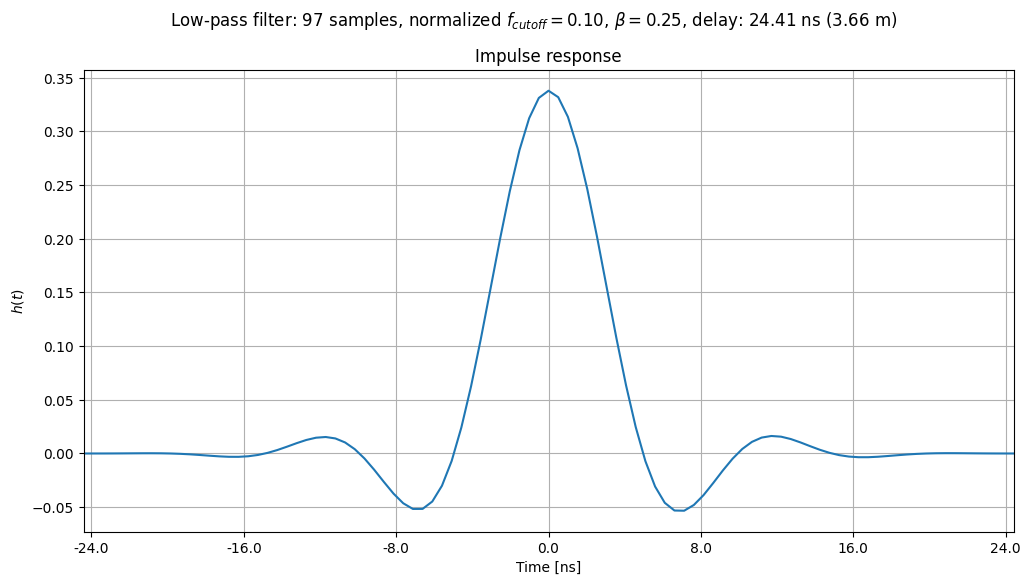

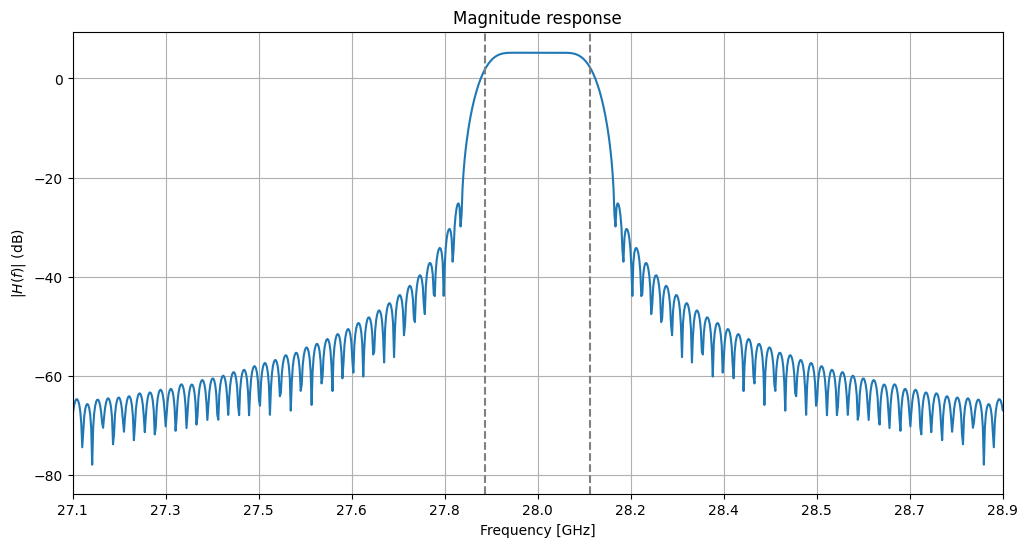

In [5]:
# Low-pass filter parameters

delay_samples = 48
cutoff_frequency = num_subcarriers/fft_size

filter_span = round(2 * delay_samples * cutoff_frequency)
oversampling = 1/cutoff_frequency

rc_beta = 0.25
rc_win  = "hann"

lp_filter = RaisedCosineFilter(span_in_symbols=filter_span, samples_per_symbol=oversampling,
                               beta=rc_beta, window=rc_win)
filter_length = int(lp_filter.length)
delay_s = filter_length//2 * Ts_sec

stick_max = round(delay_s*1e9)
stick_ns = np.linspace(-stick_max, stick_max, 7)
sticks = stick_ns*1e-9/(oversampling*Ts_sec)

lp_filter.show("impulse")
plt.suptitle(rf"Low-pass filter: {filter_length} samples, normalized $f_{'{cutoff}'}={cutoff_frequency:.2f}$, $\beta={rc_beta}$" +
             f", delay: {delay_s * 1e9:.2f} ns ({phy.delay2distance(delay_s):.2f} m)")
ax_ir = plt.gca()
ax_ir.set_xticks(sticks, np.round(stick_ns))
ax_ir.set_xlabel("Time [ns]")

lp_filter.show("magnitude", "db") # Logarithmic scale
ax_freq = plt.gca()


ftick_max = np.ceil(8*sig_bw/2e6/100)*100
ftick_mhz = np.linspace(-ftick_max, ftick_max, 11)
fticks = ftick_mhz/(cutoff_frequency*digital_bw_hz/1e6)
ftick_ghz = ftick_mhz/1e3 + fc/1e9
ax_freq.set_xticks(fticks, np.round(ftick_ghz,1))
ax_freq.set_xlim(fticks[0], fticks[-1])
ax_freq.set_xlabel("Frequency [GHz]")

ylim = ax_freq.get_ylim()
ax_freq.plot([-0.5] * 2, ylim, "--", color="gray")
ax_freq.plot([0.5] * 2, ylim, "--", color="gray")
_ = ax_freq.set_ylim(ylim)

## Ray-tracing
### Scene setup

In [6]:
scene = load_scene(scene_path)
scene.frequency = fc

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = ula_el_spacing,
                          horizontal_spacing= ula_el_spacing,
                          pattern=tx_pattern)

scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing = ula_el_spacing,
                          horizontal_spacing = ula_el_spacing,
                          pattern=rx_pattern)

# tx and rx in cartesian coordinate
tx_position, rx_position = rtr.tx_rx_positions(N_t, N_r, scene.wavelength, min_dist_el=tx_rx_dist_el,
                                               transceiver_position=(0, 0, height_m))

# Create transmitter
tx = Transmitter(name = "tx",
    position = tx_position)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
    position = rx_position)

# Add receiver instance to scene
scene.add(rx)

my_cam = Camera("my_cam", position=[2.5,0,10], look_at=[2.5,0,1])
scene.add(my_cam)

In [7]:
# Specular reflection for wall, Diffuse scattering for tgt
# Target and wall must have different materials
wall_rm = "itu_metal"
tgt_rm = "itu_concrete"
assert wall_rm != tgt_name, f"Wall and target must have different materials; both are {wall_rm}"

scattering_coefficients = {
    tgt_rm: 1.0,
    wall_rm: 0.0
}
rtr.set_scattering(scattering_coefficients, scene)

In [8]:
scene.get(wall_name).position = wall_position
scene.get(wall_name).look_at(transceiver_pos)
scene.get(tgt_name).radio_material = tgt_rm

### Path computation

In [9]:
scene.synthetic_array = True

# Move wall away to speed up simulation
scene.get(wall_name).radio_material = "vacuum"
scene.get(wall_name).position = inf_position

scene.get(tgt_name).radio_material = tgt_rm
scene.get(tgt_name).position = tgt_position

tgt_kwargs = dict(los=False, reflection=False, scattering=True, diffraction=False)
paths_tgt = scene.compute_paths(method='fibonacci', max_depth=1, scat_keep_prob=1.0,
                               **tgt_kwargs)
paths_tgt.normalize_delays = False
h_tgt, tau_tgt = paths_tgt.cir(**tgt_kwargs)

In [10]:
# Compute tgt paths again without synthetic array just for preview
scene.synthetic_array = False
preview_paths_tgt = scene.compute_paths(method='fibonacci', max_depth=1, scat_keep_prob=0.8,
                                        **tgt_kwargs)
preview_paths_tgt.normalize_delays = False

In [11]:
# SI simulation
scene.synthetic_array = False

scene.get(wall_name).radio_material = wall_rm
scene.get(wall_name).position = wall_position

si_kwargs = dict(scattering=False, diffraction=False)
paths_si = scene.compute_paths(method='exhaustive', max_depth=1,
                               los=True, reflection=True, **si_kwargs)
paths_si.normalize_delays = False
h_si_l, tau_si_l = paths_si.cir(los=True, reflection=False,
                                **si_kwargs)
h_si_r, tau_si_r = paths_si.cir(los=False, reflection=True,
                                **si_kwargs)

In [12]:
full_pdict = rtr.concatenate_paths([paths_si.to_dict(), preview_paths_tgt.to_dict()], zero_paths=False)
full_paths = copy(paths_si)
full_paths.from_dict(full_pdict)

In [13]:
render_resolution = [960, 540]
scene.preview(full_paths, show_paths=True, show_devices=True, resolution=render_resolution)

Renderer(camera=PerspectiveCamera(aspect=1.7777777777777777, children=(DirectionalLight(intensity=0.25, positi…

Compute "analog" channels with low-pass filter

In [14]:
h_si = tf.concat([h_si_l, h_si_r], axis=0)
tau_si = tf.concat([tau_si_l, tau_si_r], axis=0)

ht_si = cir_to_time_channel(digital_bw_hz, h_si, tau_si,
                            l_min=0, l_max=cyclic_prefix_length + lp_filter.length, normalize=False)
ht_tgt = cir_to_time_channel(digital_bw_hz, h_tgt, tau_tgt,
                             l_min=0, l_max=cyclic_prefix_length + lp_filter.length, normalize=False)
ht_si = lp_filter(ht_si, padding="same")[...,:cyclic_prefix_length]
ht_tgt = lp_filter(ht_tgt, padding="same")[...,:cyclic_prefix_length]

In [15]:
ht_tgt.shape

TensorShape([1, 1, 8, 1, 8, 1, 2176])

In [16]:
frac_bandwidth = cutoff_frequency
h_mimo_tgt = np.squeeze(ht_tgt)
radar_power_profile = np.sum(np.abs(h_mimo_tgt) ** 2, axis=(0, 1))/frac_bandwidth

h_mimo_si = np.squeeze(ht_si)
si_power = np.sum(np.abs(h_mimo_si) ** 2, axis=tuple(range(1,int(h_mimo_si.ndim))))/frac_bandwidth
si_power_db = phy.pow2db(si_power)


rcs_display = ["#### Resulting values\n"]
rcs_table = TextTable(header=["Parameter", "Value", "Unit"], align=("left", "right", "left"))

rcs_sim = phy.estimate_rcs(radar_power_profile, distance_m, wavelength_m, g_tx, g_rx)
rcs_table.row(["Target RCS", f"{tgt_rcs_m2:.1f}", "m$^2$"])
rcs_table.row(["Simulated RCS", f"{rcs_sim:.1f}", "m$^2$"])

rcs_ratio = np.sqrt(tgt_rcs_m2/rcs_sim)


ht_tgt *= rcs_ratio
h_tgt *= rcs_ratio
ch_gain = rcs_ratio ** 2 * np.sum(radar_power_profile)

rcs_table.row(["Channel gain", f"{phy.pow2db(ch_gain):.1f}", "dB"])
display(Markdown("\n".join(rcs_display + [rcs_table.output()])))

#### Resulting values

| Parameter |    Value | Unit     |
|:----------|---------:|:---------|
| Target RCS |      1.0 | m$^2$    |
| Simulated RCS |      1.9 | m$^2$    |
| Channel gain |   -113.1 | dB       |

### Path plots

for every Tx-Rx path, in dB as a function of both delay and distance

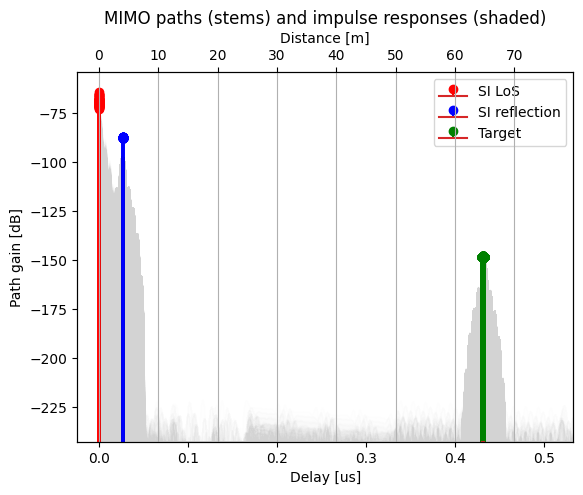

In [17]:
ht_db = phy.mag2db(tf.abs(tf.squeeze(tf.reduce_sum(ht_si, axis=0) + ht_tgt)) + 1e-30)

h_sl_db = phy.mag2db(np.abs(tf.squeeze(h_si_l).numpy())).flatten()
h_sr_db = phy.mag2db(np.abs(tf.squeeze(h_si_r).numpy())).flatten()
h_tgt_db = phy.mag2db(np.abs(tf.squeeze(h_tgt).numpy())).flatten()

t_sl = tf.squeeze(tau_si_l).numpy().flatten()
t_sr = tf.squeeze(tau_si_r).numpy().flatten()
t_tgt = tf.squeeze(np.ones(shape=h_tgt.shape[:-1]) * tau_tgt).numpy().flatten()

min_db, max_db = [f(np.concatenate([h_sl_db, h_sr_db, h_tgt_db])) for f in (np.min, np.max)]
min_y = np.mean(ht_db)
max_y = max_db + 10

filt_delay_us = delay_s *1e6
t_channel_us = t_channel_s*1e6

for h in np.reshape(ht_db, (-1, cyclic_prefix_length)):
    h_min = np.ones_like(h) * min_y
    plt.fill_between(t_channel_us, h, min_y, color='lightgray', alpha=0.01)

for h, t, label, color in zip((h_sl_db, h_sr_db, h_tgt_db), (t_sl, t_sr, t_tgt),
                       ("SI LoS", "SI reflection", "Target"), ("r", "b", "g")):
    plt.stem(t*1e6, h, bottom=min_y, label=label, linefmt=color)

tmin_us, tmax_us = -delay_s*1e6, max(t_tgt)*1e6 + 0.1

plt.legend()
plt.xlim(tmin_us, tmax_us)

plt.ylim(min_y, max_y)
plt.xlabel("Delay [us]")
plt.ylabel("Path gain [dB]")

ax2 = plt.gca().twiny()
ax2.set_xlim(phy.delay2distance(tmin_us * 1e-6), phy.delay2distance(tmax_us * 1e-6))
ax2.set_xlabel("Distance [m]")
ax2.grid(which="both")
_ = plt.title("MIMO paths (stems) and impulse responses (shaded)")

## Result storage

In [18]:
np.savez(res_path/"channel_paths.npz",
         h_si=h_si.numpy(), tau_si=tau_si.numpy(),
         h_tgt=h_tgt.numpy(), tau_tgt=tau_tgt.numpy())

In [19]:
np.savez(res_path/"channel_impulse_responses.npz",
         ht_si=ht_si.numpy(), ht_tgt=ht_tgt.numpy(),
         t_channel_s=t_channel_s)

For the self-interference channel, the $P$ MIMO matrices
$\lbrace{\bf H}_p(\tau^*_p)\rbrace^P_{p=1}$
are taken at the instants
$\lbrace\tau^*_p\rbrace^P_{p=1}$, with

$\tau^*_p=\mathrm{median}_{i,j}\max_\tau{|[{\bf H}_{p}(\tau)]_{i,j}|}$

and $p,i,j$ indexing the paths, the Tx and Rx antenna elements, respectively.

In [20]:
ht_squeeze = tf.squeeze(ht_si)
si_taps = tf.argmax(tf.abs(ht_squeeze), axis=-1)
si_indices = np.median(si_taps, axis=(1,2)).astype(int)
h_si_matrix = tf.stack([ht_squeeze[n, ..., i] for n, i in enumerate(si_indices)], axis=0)
t_si_matrix = tf.reshape(t_channel_s[si_indices,],
                         shape=[si_indices.shape[0] if n == 0 else 1
                                for n in range(h_si_matrix.ndim)])
print(f"Self-interference delays (ns): {np.round(np.squeeze(t_si_matrix * 1e9), 2)}")

Self-interference delays (ns): [ 0.   26.45]


In [21]:
np.savez(res_path/"si_mimo.npz",
         h_si_matrix=h_si_matrix.numpy(),
         t_si_matrix=t_si_matrix.numpy(),
         h_si_db=si_power_db)